# Traditional Hopfield Network

Load toy dataset.

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np

In [2]:
from sklearn import datasets

data_dict = datasets.load_digits()
data_all = data_dict['data']
data_all[data_all < 8] = -1
data_all[data_all >= 8] = 1
data_all.shape

(1797, 64)

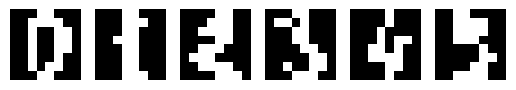

In [3]:
N = 6
data = data_all[:N]
img_s = int(np.sqrt(data.shape[-1]))
fig, ax = plt.subplots(1, N)
for i in range(N):
    if N == 1 : ax = [ax]
    ax[i].imshow(data[i].reshape(img_s, img_s), cmap='gray')
    ax[i].set_axis_off()
plt.show()

### Weight Matrix

Store N patterns $\{x_i\}_{i=1}^N$. In classical Hopfield Networks these patterns are polar (binary), i.e. $x_i \in \{-1,1\}^d$, where $d$ is the length of the patterns. The corresponding weight matrix W is:

$$
W = \sum_{i=1}^{N} x_i x_i^T
$$

In [4]:
d = data.shape[-1]
weight_matrix = np.zeros((d, d))
for i in range(N):
    weight_matrix += np.outer(data[i], data[i])

print('Weight matrix W')
weight_matrix.shape

Weight matrix W


(64, 64)

The weight matrix W stores the patterns, which can be retrieved starting with a state pattern $\xi$.

### Update Rule and Energy Function

Update rule
$$
\xi^{t+1} = \text{sgn}(W\xi^t - b)
$$

where $b \in \mathbb{R}^d$ is a bias vector. Convergence is reached if $\xi^{t+1}=\xi^t$.

It minimizes the energy function $E$:
$$
E = -\frac{1}{2} \xi^T W \xi+\xi^T b
$$

the convergence properties are dependent on the structure of the weight matrix $W$ and the method by which the nodes are updated:
- For asynchronous updates with $w_{ii}\geq 0$ and $w_{ij}=w_{ji}$, the updates converge to a stable state.
- For synchronous updates with $w_{ij}=w_{ji}$, the updates converge to a stable state or a limit cycle of length 2.

For the asynchronous update rule and symmetric weights, $E(\xi^{t+1})\leq E(\xi^t)$ holds. When $E(\xi^{t+1})= E(\xi^t)$ for the update of every component of $\xi^t$, a local minimum in $E$ is reached. All stored patterns $\{x_i\}_{i=1}^N$ should be fixed points of the Hopfield Network, i.e. $x_i = \text{sgn}(Wx_i-b)$.

In [5]:
def update_rule(W, xi_t, bias):
    return np.sign(np.dot(W, xi_t) - bias)

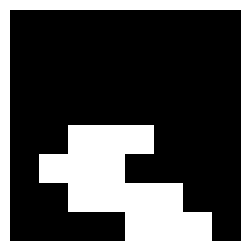

In [6]:
initial_state = data[2].copy()
initial_state[:int(initial_state.shape[0]/2)] = -1

plt.figure(figsize=(3, 3))
plt.imshow(initial_state.reshape(img_s, img_s), cmap='gray')
plt.axis('off')
plt.show()

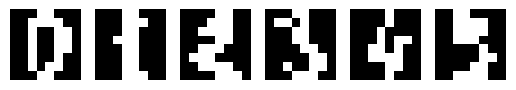

Number of updates: 4


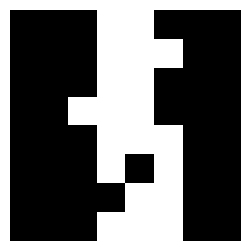

In [7]:
#### Plot all stored data again
N = 6
data = data_all[:N]
img_s = int(np.sqrt(data.shape[-1]))
fig, ax = plt.subplots(1, N)
for i in range(N):
    if N == 1 : ax = [ax]
    ax[i].imshow(data[i].reshape(img_s, img_s), cmap='gray')
    ax[i].set_axis_off()
plt.show()
#### Plot all stored data again

state_t = initial_state
state_t1 = None

steps = 0

while True:
    state_t1 = update_rule(weight_matrix, state_t, np.zeros_like(state_t))
    
    if np.allclose(state_t1, state_t):
        break
    
    steps += 1
    state_t = state_t1

print("Number of updates:", steps)
plt.figure(figsize=(3, 3))
plt.imshow(state_t1.reshape(img_s, img_s), cmap='gray')
plt.axis('off')
plt.show()

Difficult to retrieve original pattern if they are too correlated to each other.

The storage capacity for retrieval of patterns free of errors is:
$$
C \approx \frac{d}{2\text{log}(d)}
$$

Insufficient storage capacity is not directly responsible for the retrieval errors. Instead, the example patterns are correlated, therefore the retrieval has errors.

In [8]:
C = d / (2 * np.log(d))
print("Storage capacity:", C)

Storage capacity: 7.694373551407805


# Modern Hopfield Network
(aka Dense Associative Memories)

It introduces a new energy function
$$
E = -\sum_{i=1}^{N} F(x_i^T\xi)
$$
where $F$ is an interaction function. Krotov and Hopfield chose a polynomial function $F(z)=z^a$.
The storage capacity for retrieval of patterns with a small percentage of errors is $C \approx \alpha_ad^{a-1}$ where $\alpha_a$ is a constant, which depends on an (arbitrary) threshold on the error probability. For $a=2$, the classical Hopfield model (Hopfield 1982) is obtained.

Demircigil et al. extended the energy function by using an exponential interaction function:
$$
E = -\sum_{i=1}^N \text{exp}(x_i^T\xi) = -\text{exp}\left(\text{lse}(1, X^T\xi)\right)
$$
where $X=(x_1, ..., x_N)$ is the data matrix (matrix of stored patterns) and the log-sum-exp function (lse) is defined as:
$$
\text{lse}=\beta^{-1}\text{log}\left(\sum_{l=1}^N \text{exp}(\beta z_l)\right)
$$

This energy function leads to the storage capacity $C \approx 2^{d/2}$.

The update rule for the $l$-th component $\xi[l]$ is described by the difference of the energy of the current state $\xi$ and the state with the component $\xi[l]$ flipped:
$$
\xi^{\text{new}}[l] = \text{sgn}\left[-E(\xi^{(l+)}) + E(\xi^{(l-)}) \right] = \text{sgn}\left[\sum_{i=1}^N \text{exp}(x_i^T\xi^{(l+)}) - \sum_{i=1}^N \text{exp}(x_i^T\xi^{(l-)}) \right]
$$
where $\xi^{(l+)}[l] = 1$ and $\xi^{(l-)}[l] = -1$ and $\xi^{(l+)}[k] = \xi^{(l-)}[k] = \xi[k]$ for $k \neq l$.

In contrast to classical Hopfield Networks, modern Hopfield Networks do not have a weight matrix. Instead, the energy function is the sum of a function of the dot product of every stored pattern $x_i$ with the state pattern $\xi$.

In [9]:
from scipy.special import logsumexp

In [10]:
def energy_func(X, xi, N):
    e = 0
    for i in range(N):
        e-=np.exp(X[i].dot(xi))
    return e

def energy_func_lse(X, xi):
    return -np.exp(logsumexp(np.dot(X, xi)))

def update_rule(X, xi):
    """
    Demircigil et al. modern Hopfield network update rule
    """
    xi_new = np.zeros_like(xi)

    xi_lplus = np.tile(xi, (len(xi),1))
    np.fill_diagonal(xi_lplus, 1)

    xi_lminus = xi_lplus.copy()
    np.fill_diagonal(xi_lminus, -1)
    
    for l in range(len(xi)):
        xi_new[l] = np.sign(energy_func_lse(X, xi_lminus[l]) - energy_func_lse(X, xi_lplus[l]))
    
    xi_new[xi_new==0] = -1
    return xi_new


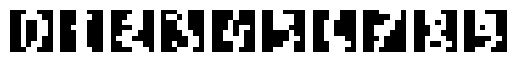

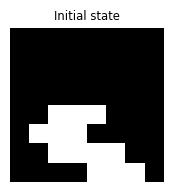

Number of updates: 1


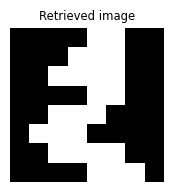

In [11]:
#### Plot all stored data again
N = 10
data = data_all[:N]
img_s = int(np.sqrt(data.shape[-1]))
fig, ax = plt.subplots(1, N)
for i in range(N):
    if N == 1 : ax = [ax]
    ax[i].imshow(data[i].reshape(img_s, img_s), cmap='gray')
    ax[i].set_axis_off()
plt.show()
#### Plot all stored data again

initial_state = data[2].copy()
initial_state[:int(initial_state.shape[0]/2)] = -1

plt.figure(figsize=(2, 2))
plt.title("Initial state", fontsize='small')
plt.imshow(initial_state.reshape(img_s, img_s), cmap='gray')
plt.axis('off')
plt.show()

state_t = initial_state
state_t1 = None

steps = 0

while True:
    state_t1 = update_rule(data, state_t)
    
    if np.allclose(state_t1, state_t) or steps > 1_000:
        break
    
    steps += 1
    state_t = state_t1

print("Number of updates:", steps)
plt.figure(figsize=(2, 2))
plt.title("Retrieved image", fontsize='small')
plt.imshow(state_t1.reshape(img_s, img_s), cmap='gray')
plt.axis('off')
plt.show()

# New Energy Function

generalization of the previous energy function to continuous-valued patterns. The quadratic term ensures that the norm of the state $\xi$ remains finite. The new energy function is defined as:
$$
E = -\text{lse}(\beta, X^T\xi)+\frac{1}{2}\xi^T\xi+\beta^{-1}\text{log}N+\frac{1}{2}M^2
$$
which is constructed from $N$ continuous stored patterns by the matrix $X=(x_1,...,x_N)$, where $M$ is the largest norm of all stored patterns.

According to the new paper of Krotov and Hopfield, the stored patterns $X^T$ can be viewed as weights from $\xi$ to hidden units, while $X$ can be viewed as weights from the hidden units to $\xi$. Patterns are not stored, but only weights are used in the model as in the classical Hopfield Network.

This energy function allows deriving an update rule for a state pattern $\xi$ by the Concave-Convex-Procedure (CCCP), which is described by Yuille and Rangarajan. The total energy is split into a convex and a concave term: the term $\frac{1}{2}\xi^T\xi+C$ is convex, and the term $-\text{lse}(\beta, X^T\xi)$ is concave.
$$
\xi^{\text{new}}=X\text{softmax}(\beta X^T \xi)
$$
Having applied the CCCP to obtain the update rule guarantees the monotonical decrease of the energy function. The most important properties of the new energy function are:
1. Global convergence to a local minimum.
2. Exponential storage capacity.
3. Convergence after one update step.


In [12]:
from scipy.special import softmax

class HopfieldAllYouNeed:
    def __init__(self, data, beta):
        """
        data: data matrix (features, N)
        beta: inverse temperature
        """
        self.beta = beta
        self.X = data.copy()
        self.N = self.X.shape[-1]
        self.M = np.max(np.linalg.norm(self.X.T, axis=0))

    def energy_func_lse(self, xi):
        """
        xi: state vector (features,)
        """
        return -logsumexp(np.dot(self.X.T, xi)) +\
            0.5*np.dot(xi, xi) +\
            (1/self.beta)*np.log(self.N) +\
            0.5*(self.M**2)

    def update_rule(self, xi):
        """
        xi: state vector (features,)
        """
        return np.dot(
            self.X,
            softmax(self.beta*np.dot(self.X.T, xi))
        )

In [13]:
import cv2
import os
import numpy as np

np.random.seed(123)

directory = "data/simpson_faces"
data = []

N = 10

for filename in os.listdir(directory)[:500]:
    if filename.endswith(".png"):
        image_path = os.path.join(directory, filename)
        gray_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        gray_image = cv2.resize(gray_image, (64, 64))
        gray_image = gray_image.astype(np.float32) / 255.0

        # gray_image[gray_image <0.5] = -1
        # gray_image[gray_image >=0.5] = 1

        gray_image = 2 * gray_image - 1  # Rescale to [-1, 1]

        data.append(gray_image.flatten())

data = np.array(data)

data = data[np.random.choice(data.shape[0], N, replace=False), ...]
data.shape

(10, 4096)

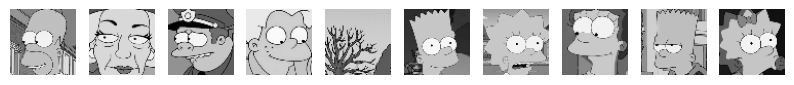

In [14]:
#### Plot all stored data
img_s = int(np.sqrt(data.shape[-1]))
fig, ax = plt.subplots(1, N, figsize=(10, 5))
for i in range(N):
    if N == 1 : ax = [ax]
    ax[i].imshow(data[i].reshape(img_s, img_s), cmap='gray')
    ax[i].set_axis_off()
plt.show()
#### Plot all stored data

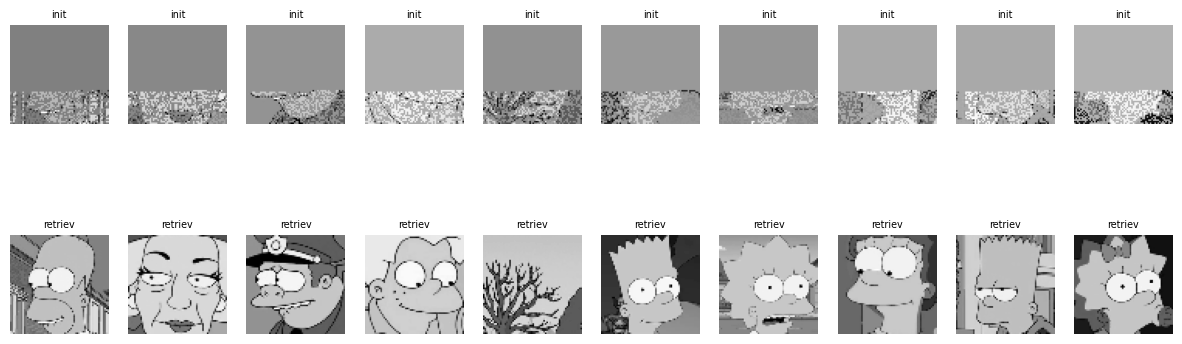

In [15]:
BETA = 8
hopfield = HopfieldAllYouNeed(data.T, beta=BETA)

fig, ax = plt.subplots(2, N, figsize=(15, 5))

for idx in range(N):

    initial_state = data[idx].copy()
    initial_state[
        np.random.choice(range(len(initial_state)), size=int(len(initial_state)*0.5), replace=False)
    ] = 0.
    initial_state[
        :int(len(initial_state)*2/3)
    ] = 0.

    ax[0, idx].set_title("init", fontsize='x-small')
    ax[0, idx].imshow(initial_state.reshape(img_s, img_s), cmap='gray')
    ax[0, idx].set_axis_off()

    state_t = initial_state
    state_t1 = None

    steps = 0

    while True:

        state_t1 = hopfield.update_rule(state_t)
        
        if np.allclose(state_t1, state_t) or steps > 1_000:
            break
        
        steps += 1
        state_t = state_t1.copy()

    ax[1, idx].set_title("retriev", fontsize='x-small')
    ax[1, idx].imshow(state_t1.reshape(img_s, img_s), cmap='gray')
    ax[1, idx].set_axis_off()

##### The update of the new energy function is the self-attention of transformer networks

$X\in\mathbb{R}^{d_{k}\times N}$ For $S$ state patterns $\Xi=(\xi_1,...,\xi_S) \in\mathbb{R}^{d_{k}\times S}$, we can generalize the update to:
$$
\Xi^{\text{new}} = X\text{softmax}(\beta X^T \Xi)
$$

We first consider $X^T$ as $N$ raw stored patterns $Y=(y_1,...,y_N)^T \in\mathbb{R}^{N\times d_y}$, which are mapped to an associative space via $W_K \in\mathbb{R}^{d_y\times d_k}$, and $\Xi^T$ as $S$ raw state patterns $R=(r_1,...,r_S)^T \in\mathbb{R}^{S\times d_r}$, which are mapped to an associative space via $W_Q \in\mathbb{R}^{d_r\times d_k}$.
$$
K = X^T = Y W_K\quad \in\mathbb{R}^{N\times d_k}\\
Q = \Xi^T = R W_Q\quad \in\mathbb{R}^{S\times d_k}\\
\beta = 1/\sqrt{d_k}
$$
and
$$
(Q^{\text{new}})^T = K^T \text{softmax}\left(\frac{1}{\sqrt{d_k}} K Q^T\right)
$$
where $W_Q$ and $W_K$ are matrices which map the respective patterns into the associative space. Note that the softmax is applied column-wise. Next, we simply transpose, which also means that the softmax is now applied row-wise:
$$
Q^{\text{new}} = \text{softmax}\left(\frac{1}{\sqrt{d_k}} Q K^T\right) K
$$
Now, we only need to project $Q^{\text{new}}$ via another projection matrix $W_V \in\mathbb{R}^{d_k\times d_v}$:
$$
Z = Q^{\text{new}} W_V = \text{softmax}\left(\frac{1}{\sqrt{d_k}} Q K^T\right) K W_V = \text{softmax}\left(\frac{1}{\sqrt{d_k}} Q K^T\right) V = \text{softmax}\left(\beta R W_Q W_K^T Y^T\right) Y W_K W_V \quad\in\mathbb{R}^{S\times d_v}
$$
and voilà, we obtain the transformer attention. In the transformer self-attention $R=Y$, and $W_K W_V$ is replaced by just $W_V$.

This can be related to image storage and retrieval as done previously by setting the maps to identity matrices.

In [16]:
from scipy.special import softmax

class HopfieldAsAttention:
    def __init__(self, data, d_k, d_r, d_v):
        """
        data: data matrix (N, features)
        d_k: dimension of associative space (aka latent dimension)
        d_r: dimension of raw state patterns
        d_v: dimension of output
        identity_maps: whether to use identity maps for W_K, W_Q, W_V
        """
        self.d_k = d_k
        self.d_r = d_r
        self.d_v = d_v

        self.Y = data.copy()
        self.d_y = self.Y.shape[-1] # number of features

        # maps to associative space
        self.W_K = np.eye(self.d_y, self.d_k) # data to associative space
        self.W_Q = np.eye(self.d_r, self.d_k) # raw state to associative space
        self.W_V = np.eye(self.d_k, self.d_v) # associative space to output

    def update_rule(self, R, beta=None):
        """
        R: raw state matrix (S, d_r)
        """
        K = np.dot(self.Y, self.W_K) # (N, d_k)
        Q = np.dot(R, self.W_Q) # (S, d_k)
        V = np.dot(K, self.W_V) # (N, d_v)

        beta = 1/np.sqrt(self.d_k) if beta is None else beta # scaling factor

        return np.dot(
            softmax(beta*np.dot(Q, K.T), axis=-1), # softmax is now applied row-wise
            V
        ) # (S, d_v)

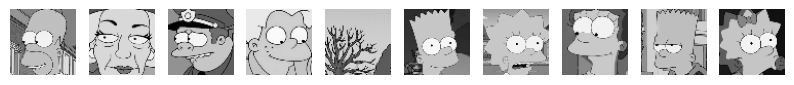

In [17]:
#### Plot all stored data
img_s = int(np.sqrt(data.shape[-1]))
fig, ax = plt.subplots(1, N, figsize=(10, 5))
for i in range(N):
    if N == 1 : ax = [ax]
    ax[i].imshow(data[i].reshape(img_s, img_s), cmap='gray')
    ax[i].set_axis_off()
plt.show()
#### Plot all stored data

(10, 4096)


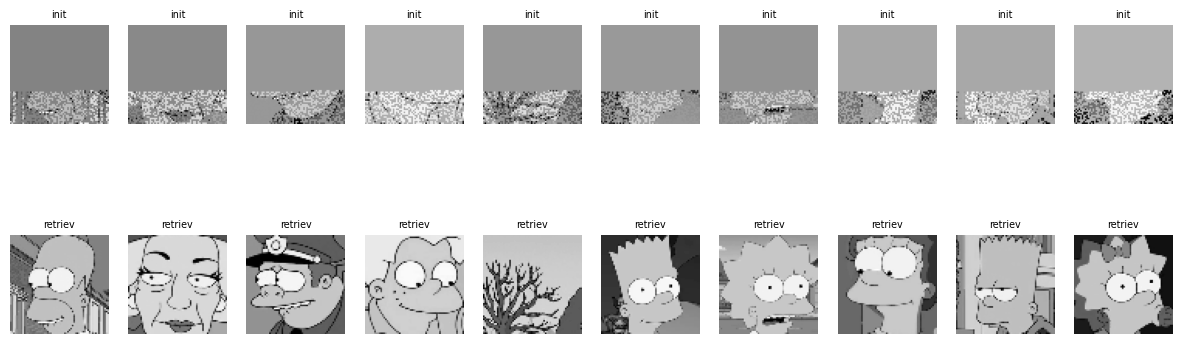

In [18]:
hopfield = HopfieldAsAttention(
    data,
    d_k = data.shape[-1], # associative space dimension same as num. of features
    d_r = data.shape[-1], # raw state dimension same as num. of features
    d_v = data.shape[-1],  # output dimension same as num. of features
)

fig, ax = plt.subplots(2, N, figsize=(15, 5))

initial_state = data.copy() # in this case S=N and d_r=d_y (num. of features)
S = initial_state.shape[0]
initial_state[
    :, np.random.choice(range(initial_state.shape[-1]), size=int(initial_state.shape[-1]*0.5), replace=False)
] = 0.
initial_state[
    :, :int(initial_state.shape[-1]*2/3)
] = 0.
print(initial_state.shape)

for idx in range(S):
    ax[0, idx].set_title("init", fontsize='x-small')
    ax[0, idx].imshow(initial_state[idx].reshape(img_s, img_s), cmap='gray')
    ax[0, idx].set_axis_off()

state_t = initial_state
state_t1 = None
state_final = np.zeros_like(state_t)
converged_idx = np.zeros(S, dtype=bool)

steps = 0

while True:
    state_t1 = hopfield.update_rule(state_t, beta=8)
    
    # how many states have already converged?
    converged_idx_curr = np.all(np.isclose(state_t1, state_t), axis=-1)

    if np.all(converged_idx_curr):
        break
    
    steps += 1
    state_t = state_t1.copy()

    # if not converged, update the states
    idx_toupdate = np.logical_and(converged_idx==False, converged_idx_curr==False)

    state_final[idx_toupdate] = state_t1[idx_toupdate]

    # keep memory of converged spaces
    converged_idx = np.logical_or(converged_idx, converged_idx_curr)

    if np.all(converged_idx) or steps > 1_000:
        break

for idx in range(S):
    ax[1, idx].set_title("retriev", fontsize='x-small')
    ax[1, idx].imshow(state_final[idx].reshape(img_s, img_s), cmap='gray')
    ax[1, idx].set_axis_off()